In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import itertools
import os
import time

# allow for .py files in canine package to be added
import sys
sys.path.insert(0, '../')

from canine.preprocessing import datahandler
from canine.plotting import results

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# used to reload .py files in src directory
%load_ext autoreload
%autoreload 2

In [2]:
# only show error messages from tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

VOL = '/mnt/data1/stock/misc/canine'
DSIZE = (224, 224) # (32, 32) (64, 64) (224, 224)
NPY_IMAGE_PATH = os.path.join(VOL, f'images_{DSIZE[0]}x{DSIZE[1]}.npy')
NPY_LABEL_PATH = os.path.join(VOL, f'labels.npy')

gpus = tf.config.get_visible_devices('GPU')
for i, device in enumerate(gpus):
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
# !nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Data Loader

In [88]:
# (optional) save the data to an np.array 

datahandler.save_data(VOL, NPY_IMAGE_PATH, NPY_LABEL_PATH, DSIZE)

finished saving images to /mnt/data1/stock/misc/canine/images_64x64.npy
finished saving labels to /mnt/data1/stock/misc/canine/labels.npy


In [10]:
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=True, remove_undefined=True)

# sit_indices = np.argwhere(labels.flatten()==1).flatten()
# labels = np.concatenate([labels, np.array([[1]] * len(sit_indices))])
# images = np.concatenate([images, images[sit_indices]])

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.70,0.15,0.15), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing']
(9990, 224, 224, 3) (9990, 1) (2141, 224, 224, 3) (2141, 1) (2139, 224, 224, 3) (2139, 1)


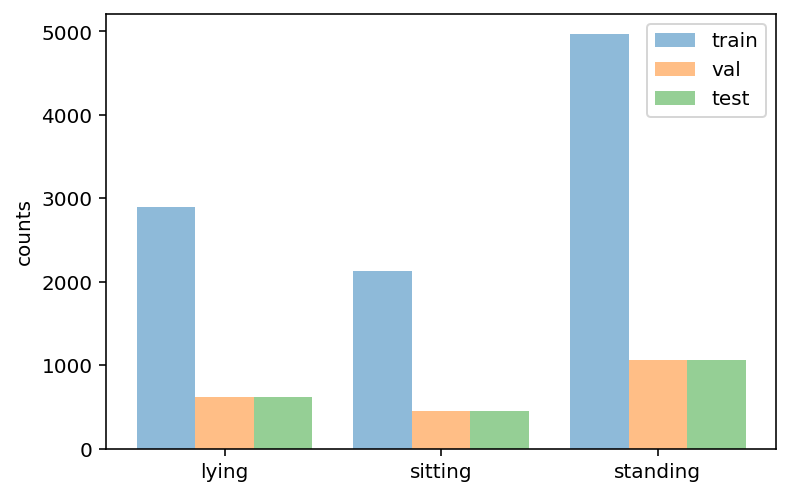

In [11]:
ind = np.arange(len(class_labels))
width = 0.27 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

_, counts = np.unique(Ttrain, return_counts=True)
rects1 = ax.bar(ind, counts, width, alpha=0.5)
_, counts = np.unique(Tvalidate, return_counts=True)
rects2 = ax.bar(ind+width, counts, width, alpha=0.5)
_, counts = np.unique(Ttest, return_counts=True)
rects3 = ax.bar(ind+width*2, counts, width, alpha=0.5)

ax.set_ylabel('counts')
ax.set_xticks(ind+width)
ax.set_xticklabels(class_labels)
ax.legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

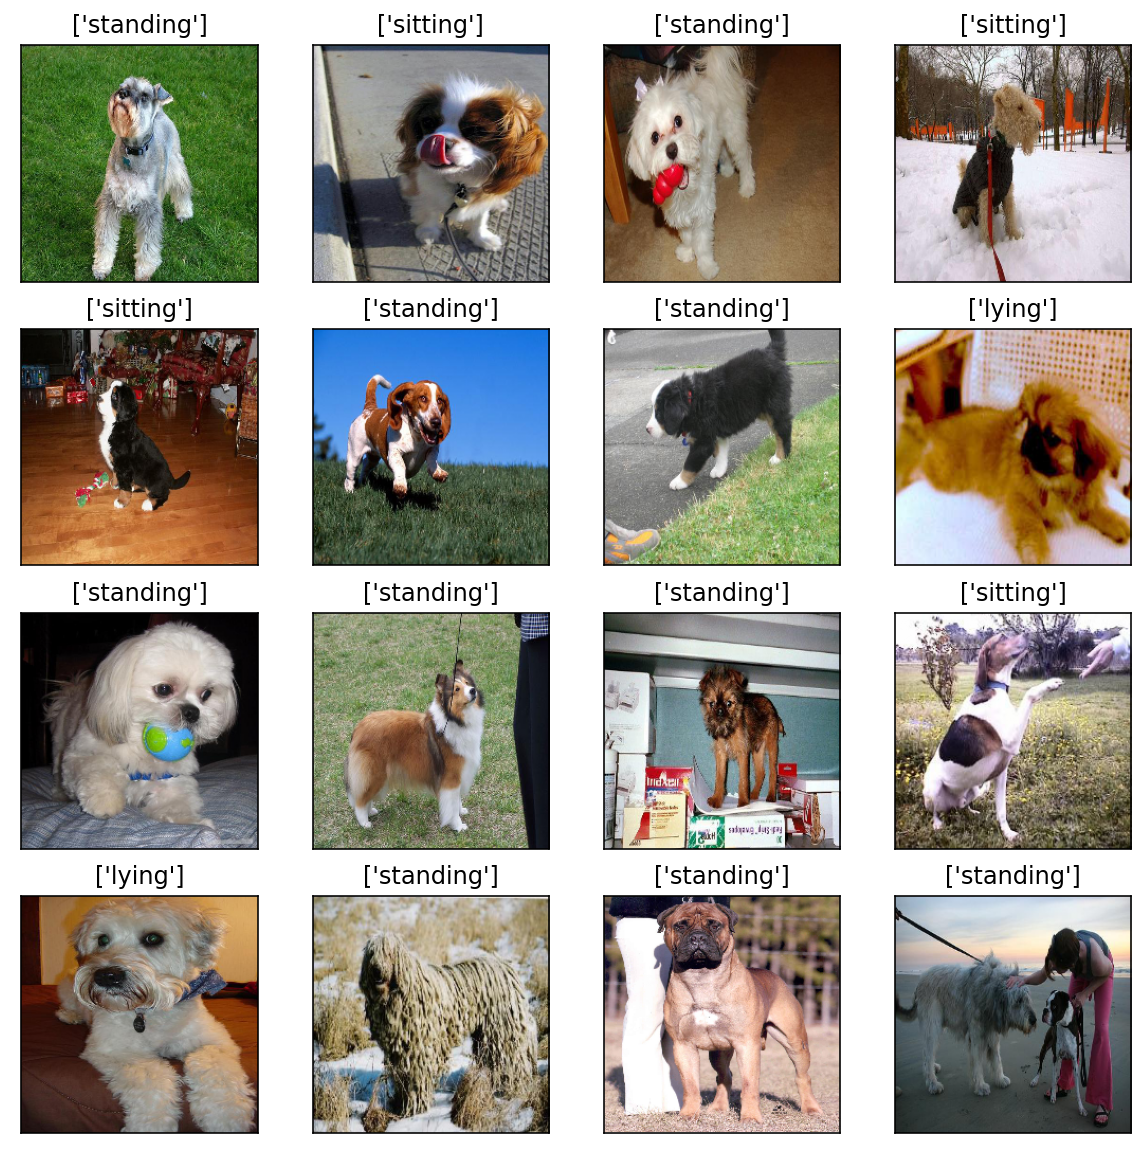

In [12]:
h, w = 4, 4
fig, axs = plt.subplots(h, w, figsize=(10, 10))
axs = axs.ravel()
for i in range(h*w):
    axs[i].imshow(Xtrain[i])
    axs[i].set_title(class_labels[Ttrain[i]])
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Topology Search

In [94]:
layers = [[32, 64, 128, 256, 512]] + [[32, 64, 128]] + [[nu] * nl for nu in [128, 256] for nl in range(2, 5)]
dense = [128]

product = list(itertools.product(dense, layers))
print(f'total of {len(product)} trials.')

epochs = 60
batch_size = 64
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

histories = []

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
], name='augmentation')

f = FloatProgress(min=0, max=len(product))
display(f)
for dense, n_units_in_conv_layers in product:
    
    kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)
    
    #setup
    tf.keras.backend.clear_session()

    X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
    # Z = data_augmentation(Z)   
    for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
        Z = tf.keras.layers.Conv2D(
            units, kernel_size=kernel, strides=stride, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
        Z = tf.keras.layers.Dropout(0.20)(Z)
        
    Z = tf.keras.layers.Dense(dense, activation='relu')(tf.keras.layers.Flatten()(Z))
    Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

    model = tf.keras.Model(inputs=X, outputs=Y)
    
    #compile 
    model.compile(optimizer=optim,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #train 
    history = model.fit(Xtrain, Ttrain, verbose=0,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(Xvalidate, Tvalidate)).history
    histories.append(history)
    
    f.value += 1

total of 8 trials.


FloatProgress(value=0.0, max=8.0)

train --  , validation -


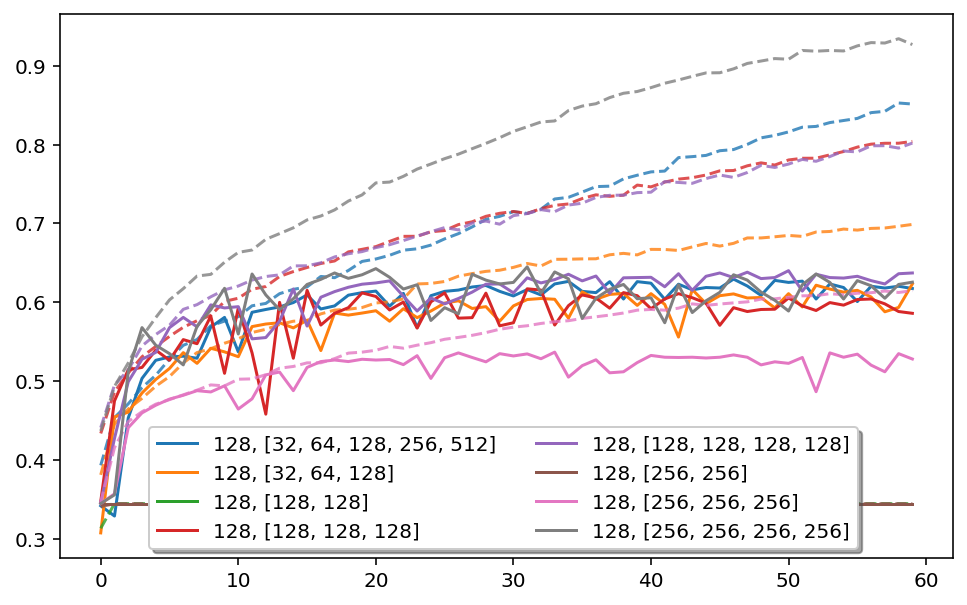

In [95]:
fig, ax = plt.subplots(figsize=(8, 5))

cmap = cm.get_cmap('tab10')
colors = [cmap.colors[i] for i in range(len(cmap.colors))]
lables = [str(p)[1:-1] for p in product]

i = 0
for h in histories:
    ax.plot(h['accuracy'], '--', color=colors[i], alpha=0.8)
    ax.plot(h['val_accuracy'], color=colors[i], label=lables[i])
    i += 1
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
lines, labels = lines_labels[0], lines_labels[1]

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0,.12,1.02,0.2),
           ncol=2, fancybox=True, shadow=True);

print('train --  , validation -')

In [96]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2    3
    ------------------------
 0 | 46.5 15.0 18.0 20.5
 1 |  7.9 48.4 26.6 17.1
 2 |  3.5  8.1 81.3  7.1
 3 |  8.6  7.9 21.7 61.8

 0 lying, 1 sitting, 2 standing, 3 undefined


# Basic Model

In [41]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(False)

epochs = 20
batch_size = 32
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
n_units_in_conv_layers = [256, 256, 256, 256]
kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
], name='augmentation')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
Z = data_augmentation(Z)
for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
    Z = tf.keras.layers.Conv2D(
        units, kernel_size=kernel, strides=stride, padding='same')(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation('relu')(Z)
    Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
    Z = tf.keras.layers.Dropout(0.20)(Z)

# https://github.com/richardaecn/class-balanced-loss/blob/
#    1d7857208a2abc03d84e35a9d5383af8225d4b4d/src/model_base.py#L196
#, bias_initializer=tf.constant_initializer(-np.log(dense_units - 1))

dense_units = 128
Z = tf.keras.layers.Dense(dense_units, activation='relu')(tf.keras.layers.Flatten()(Z))
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(inputs=X, outputs=Y)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10,
                                              mode='max', restore_best_weights=True)]

start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/20
313/313 - 64s - loss: 1.1510 - accuracy: 0.4879 - val_loss: 1.0332 - val_accuracy: 0.4974
Epoch 2/20
313/313 - 61s - loss: 0.9688 - accuracy: 0.5320 - val_loss: 0.9734 - val_accuracy: 0.5278
Epoch 3/20
313/313 - 61s - loss: 0.9480 - accuracy: 0.5412 - val_loss: 0.9790 - val_accuracy: 0.5722
Epoch 4/20
313/313 - 61s - loss: 0.9215 - accuracy: 0.5586 - val_loss: 0.9639 - val_accuracy: 0.5418
Epoch 5/20
313/313 - 61s - loss: 0.8888 - accuracy: 0.5810 - val_loss: 0.8681 - val_accuracy: 0.5908
Epoch 6/20
313/313 - 61s - loss: 0.8529 - accuracy: 0.5935 - val_loss: 0.8646 - val_accuracy: 0.5904
Epoch 7/20
313/313 - 61s - loss: 0.8383 - accuracy: 0.6034 - val_loss: 0.8276 - val_accuracy: 0.6235
Epoch 8/20
313/313 - 61s - loss: 0.8157 - accuracy: 0.6186 - val_loss: 0.8297 - val_accuracy: 0.6273
Epoch 9/20
313/313 - 61s - loss: 0.7944 - accuracy: 0.6325 - val_loss: 0.9832 - val_accuracy: 0.5329
Epoch 10/20
313/313 - 61s - loss: 0.7781 - accuracy: 0.6351 - val_loss: 0.8119 - val_accura

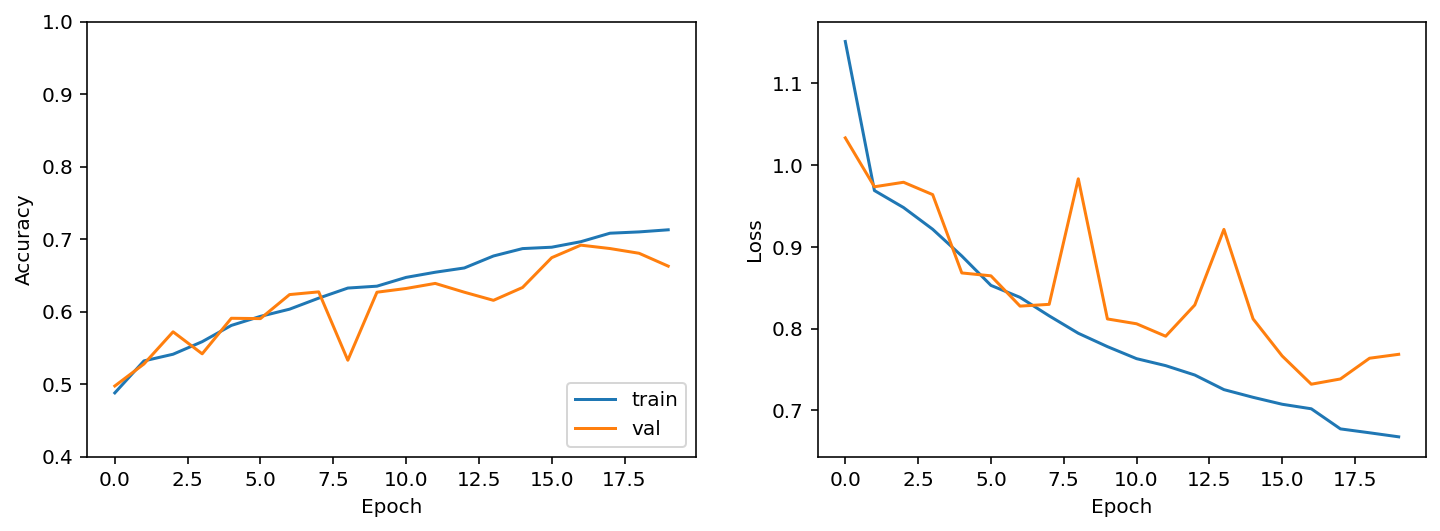

In [42]:
results.plot_history(history)

In [43]:
model.evaluate(Xtest, Ttest);

67/67 [==============================] - 25s 373ms/step - loss: 0.7266 - accuracy: 0.6882


In [44]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2
    ------------------
 0 | 83.4  8.2  8.4
 1 | 35.6 44.2 20.2
 2 | 18.7 10.4 70.8

 0 lying, 1 sitting, 2 standing


# Transfer Learning

In [8]:
# DON'T NORMALIZE for MobileNet / ResNet (use custom preprocessing layer)
# Requires shape of images to be (None, 224, 224, 3)
#
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=False, remove_undefined=False)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.75,0.15,0.1), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing' 'undefined']
(15433, 224, 224, 3) (15433, 1) (3087, 224, 224, 3) (3087, 1) (2057, 224, 224, 3) (2057, 1)


## MobileNetV2

In [7]:
tf.keras.backend.clear_session()

epochs = 15
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=base_shape,
                                               include_top=False,
                                               weights='imagenet')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                                 width_factor=(-0.1, 0.1)),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.mobilenet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z, training=True)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dropout(0.2)(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='MobileNetV2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/15
268/268 - 116s - loss: 0.9659 - accuracy: 0.5503 - val_loss: 0.7664 - val_accuracy: 0.6550
Epoch 2/15
268/268 - 31s - loss: 0.7531 - accuracy: 0.6696 - val_loss: 0.6525 - val_accuracy: 0.7163
Epoch 3/15
268/268 - 32s - loss: 0.6522 - accuracy: 0.7207 - val_loss: 0.5877 - val_accuracy: 0.7513
Epoch 4/15
268/268 - 31s - loss: 0.5874 - accuracy: 0.7469 - val_loss: 0.5476 - val_accuracy: 0.7636
Epoch 5/15
268/268 - 31s - loss: 0.5452 - accuracy: 0.7676 - val_loss: 0.5136 - val_accuracy: 0.7846
Epoch 6/15
268/268 - 31s - loss: 0.4994 - accuracy: 0.7969 - val_loss: 0.4906 - val_accuracy: 0.7944
Epoch 7/15
268/268 - 31s - loss: 0.4613 - accuracy: 0.8136 - val_loss: 0.4705 - val_accuracy: 0.8091
Epoch 8/15
268/268 - 31s - loss: 0.4351 - accuracy: 0.8223 - val_loss: 0.4555 - val_accuracy: 0.8168
Epoch 9/15
268/268 - 31s - loss: 0.4033 - accuracy: 0.8367 - val_loss: 0.4455 - val_accuracy: 0.8214
Epoch 10/15
268/268 - 31s - loss: 0.3839 - accuracy: 0.8471 - val_loss: 0.4364 - val_accur

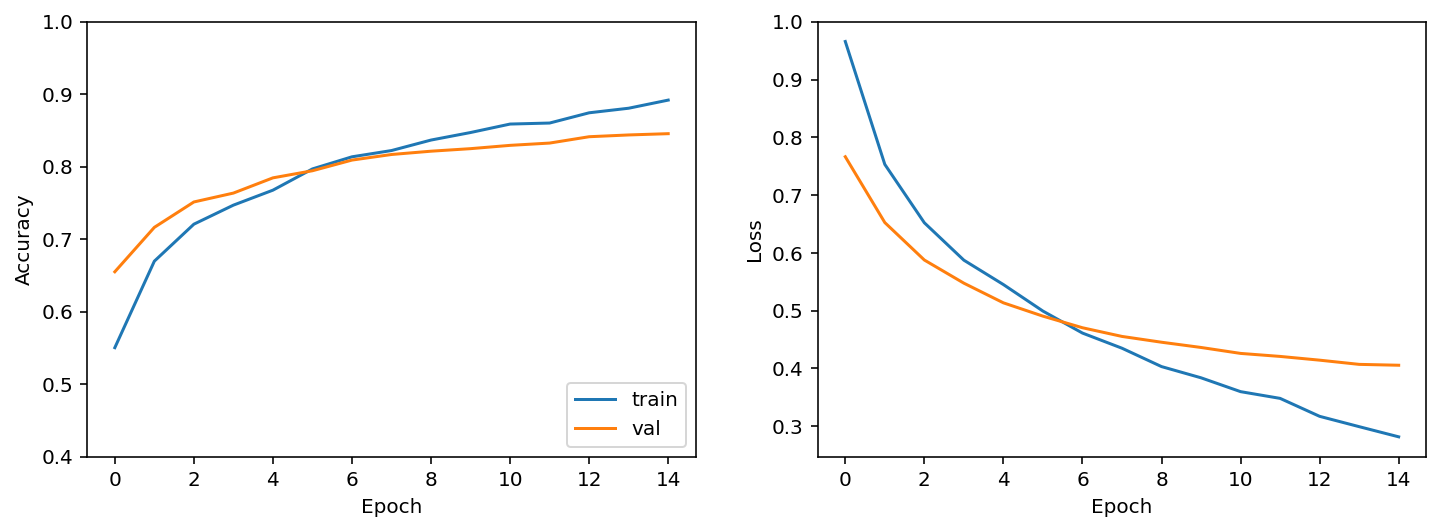

In [9]:
results.plot_history(history)

In [10]:
model.evaluate(Xtest, Ttest);

90/90 [==============================] - 40s 449ms/step - loss: 0.4106 - accuracy: 0.8398


[0.41057345271110535, 0.8398177623748779]

In [ ]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

## ResNet50V2

In [3]:
# DON'T NORMALIZE for MobileNet / ResNet (use custom preprocessing layer)
# Requires shape of images to be (None, 224, 224, 3)
#
images, labels, class_labels = datahandler.load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, 
                                                     normalize=False, remove_undefined=True)

Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = datahandler.partition_data(images, labels, 
                                                                           partition=(0.75,0.10,0.15), 
                                                                           shuffle=True)

print(class_labels)
print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

['lying' 'sitting' 'standing']
(10703, 224, 224, 3) (10703, 1) (1427, 224, 224, 3) (1427, 1) (2140, 224, 224, 3) (2140, 1)


In [4]:
tf.keras.backend.clear_session()

epochs = 2
batch_size = 32

base_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(input_shape=base_shape,
                                              include_top=False,
                                              weights='imagenet')

for layer in base_model.layers:
    # if layer.name == 'conv5_block3_2_conv':
    #     break
    # else:
    #     layer.trainable = False

    # 83% 
    # https://medium.com/@balaji.kulkarni92/transfer-learning-using-resnet-e20598314427
    # if isinstance(layer, tf.keras.layers.BatchNormalization):
    #     layer.trainable = True
    # else:
    #     layer.trainable = False
    
    # 89% without undefined.
    layer.trainable = True

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                                 width_factor=(-0.1, 0.1)),
], name='augmentation')

preprocess_input = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda X: 
        tf.keras.applications.resnet_v2.preprocess_input(X))
], name='preprocess')

X = Z = tf.keras.Input(shape=Xtrain.shape[1:], name='input')
Z = preprocess_input(tf.cast(Z, tf.float32))
Z = data_augmentation(Z)

Z = base_model(Z)

Z = tf.keras.layers.GlobalAveragePooling2D()(Z)
Z = tf.keras.layers.Dense(64, activation='relu')(Z)
Z = tf.keras.layers.Dropout(0.25)(Z)
Z = tf.keras.layers.BatchNormalization()(Z)
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(X, Y, name='ResNet50V2-Dog')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
                     
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5,
                                              restore_best_weights=True)]
    
start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/2
335/335 - 155s - loss: 1.0820 - accuracy: 0.5206 - val_loss: 0.7711 - val_accuracy: 0.6861
Epoch 2/2
335/335 - 42s - loss: 0.7100 - accuracy: 0.7103 - val_loss: 0.6432 - val_accuracy: 0.7526
Finished in 283.641 seconds.


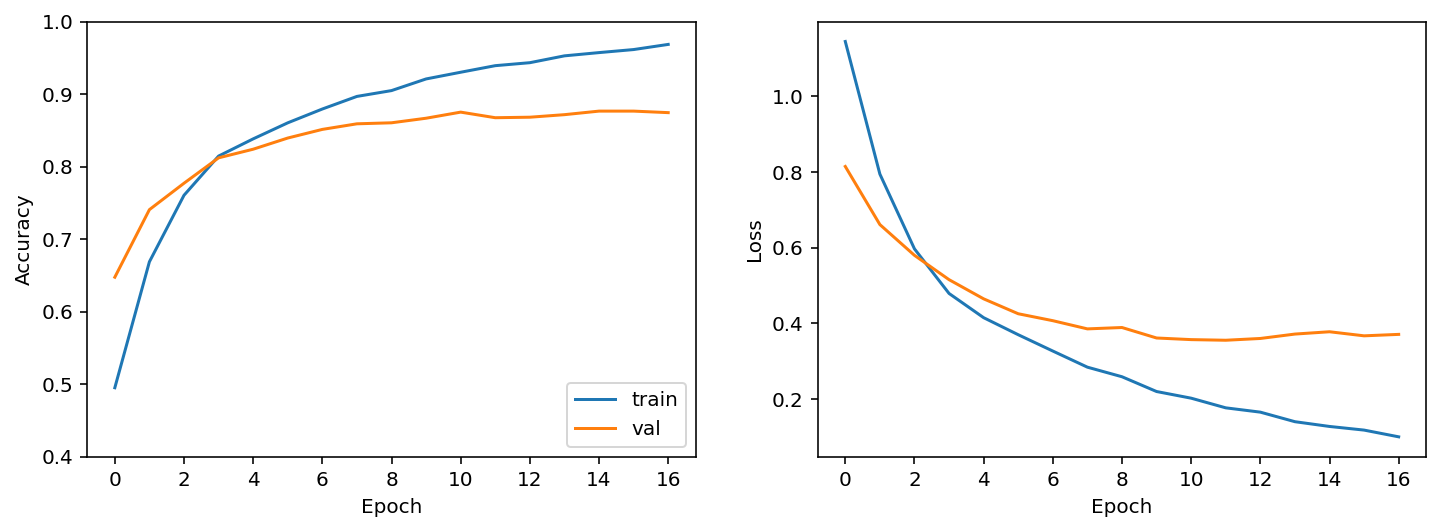

In [8]:
results.plot_history(history)

In [9]:
model.evaluate(Xtest, Ttest);

67/67 [==============================] - 60s 896ms/step - loss: 0.3163 - accuracy: 0.8883


In [10]:
Y = model.predict(Xtest).argmax(axis=1).reshape(-1,1)
results.confusion_matrix(Ttest, Y, np.arange(len(class_labels)));
print('\n', ', '.join([ f'{i} {class_labels[i]}' for i in range(len(class_labels))]))

       0    1    2
    ------------------
 0 | 88.7  6.1  5.2
 1 | 10.3 78.9 10.7
 2 |  2.4  4.4 93.1

 0 lying, 1 sitting, 2 standing


## Explainers

In [17]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.activations import ExtractActivations 
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad

In [51]:
def interpret_input(nnet, X, T, class_labels, save=False):

    class_name = class_labels[T[0][0]]
    
    Y = nnet.predict(X)
    Y_i = Y.argmax(axis=1)[0]

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(X[0]) # / 255.)
    ax.set_title(f'T: {class_name}, Y: {class_labels[Y_i]} ({Y[0, Y_i]*100:.3f}%)')
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)
    
    explainers = [GradCAM(), VanillaGradients(), GradientsInputs(),
          IntegratedGradients(), OcclusionSensitivity(), SmoothGrad()]
    
    explainers_name = ['Grad CAM', 'Vanilla Gradients', 'Gradients Inputs',
                       'Integrated Gradients', 'Occlusion Sensitivity', 'Smooth Grad']

    fig, axs = plt.subplots(2,3,figsize=(8, 6))
    axs = axs.ravel()
    [axi.set_axis_off() for axi in axs]
    
    for i in range(len(explainers)):
        if 'Occlusion Sensitivity' == explainers_name[i]: 
            grid = explainers[i].explain((X, T), nnet, class_index=T[0][0], patch_size=15)
        else:
            grid = explainers[i].explain((X, T), nnet, class_index=T[0][0])
        im = axs[i].imshow(grid)
        fig.colorbar(im, ax=axs[i], shrink=0.62)
        axs[i].set_title(explainers_name[i], size=11)
        
    fig.tight_layout();
    
    if save:
        plt.savefig('media/' + f'interpret_{str(class_name)}.png', bbox_inches='tight', dpi=300)

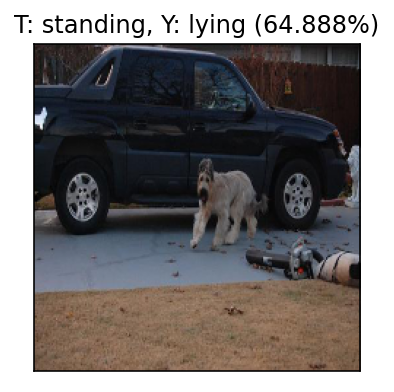

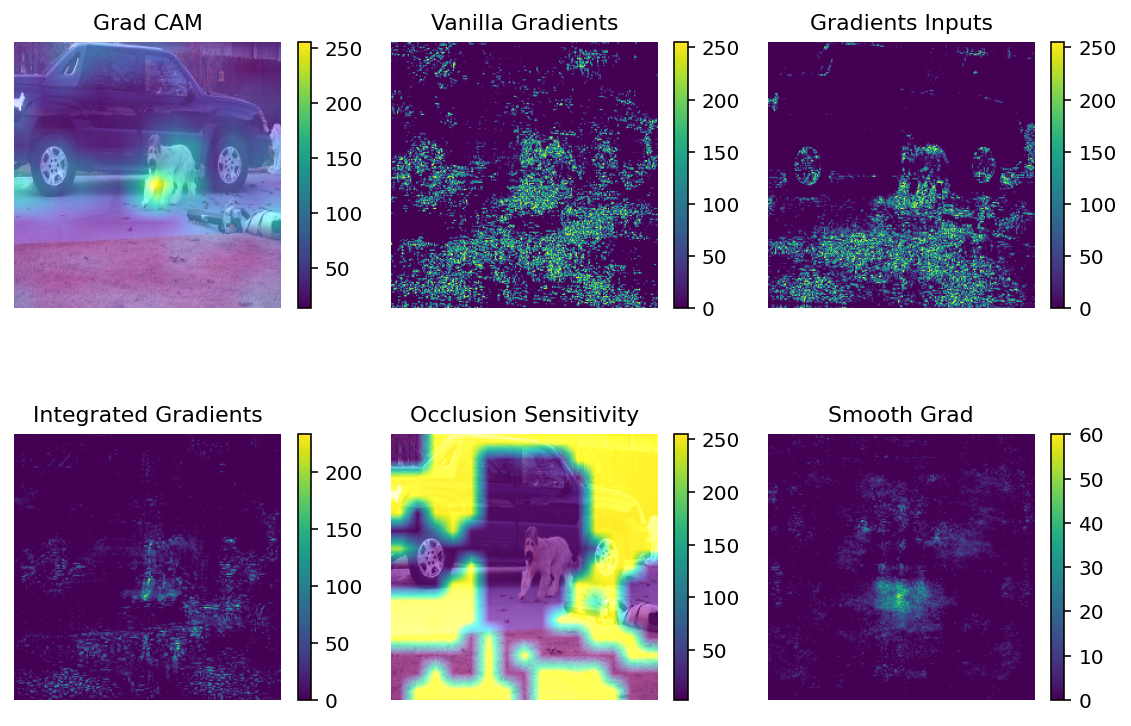

In [98]:
tf.config.run_functions_eagerly(True)

i = 25
interpret_input(model, Xtest[i:i+1], Ttest[i:i+1], class_labels, save=False)